# CNN on Translational MNIST (LITE)

This notebook is similar to the previous examples where we applied CNN on MNIST dataset. In this notebook, we re-visit the question of how much the network performance is effected by introducing a horizontal and vertical translation of features.

## Goal:
* Train CNN on MNIST, inspect the performance when digits are shifted for test time.

In [1]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import torch
import numpy as np
SEED=123
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

We will use [`kmi.utils`](https://github.com/drinkingkazu/kmi/blob/master/utils) package. In case it's not available here, curl it.

In [2]:
![ -d kmi ] || git clone https://github.com/drinkingkazu/kmi
! cd kmi && git pull

Already up to date.


# Prepare dataset

Train dataset


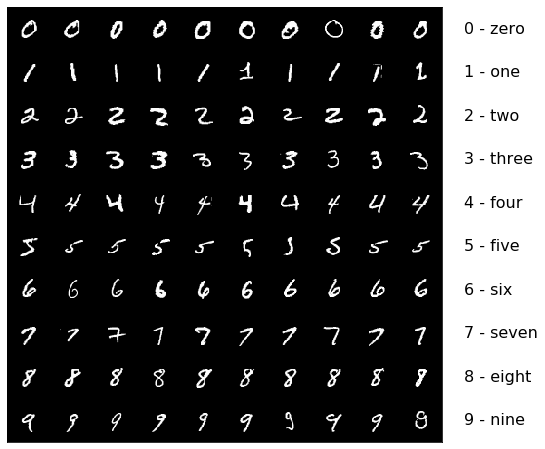

Test dataset


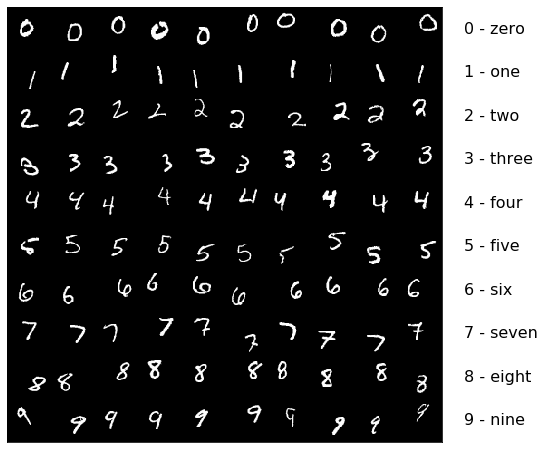

In [3]:
from torchvision import datasets, transforms
from kmi.utils import ImagePadder
# Data file download directory
LOCAL_DATA_DIR = './data'
# Prepare train data
train_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                               transform=transforms.Compose([ImagePadder(randomize=False),transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=1,pin_memory=True)
# Prepare test data
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([ImagePadder(randomize=True),transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=40,shuffle=False,num_workers=2,pin_memory=True)
# Visualize classes
from kmi.utils import plot_dataset
print('Train dataset')
plot_dataset(train_dataset)
print('Test dataset')
plot_dataset(test_dataset)

<a href="network"></a>
# Define a network

In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,5,padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,5,padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,5,padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(6,6))
        # classifier MLP
        self._classifier = torch.nn.Linear(128,10)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

# Create Blob

In [5]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

<a href="train"></a>
# Train

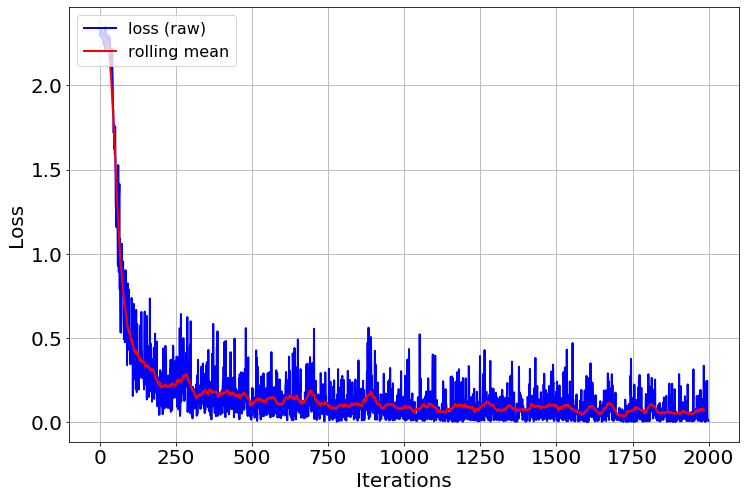

In [6]:
# Import train_loop, plot_loss
from kmi.utils import train_loop, plot_loss, save_state
# Train
plot_loss(train_loop(blob,train_loader,num_iteration=2000))
# Save
blob.weight_file=save_state(blob,prefix='./MNIST-MLP-LITE')

# Evaluation

Train set accuracy mean 0.9842666666666666 std 0.022784400121330574


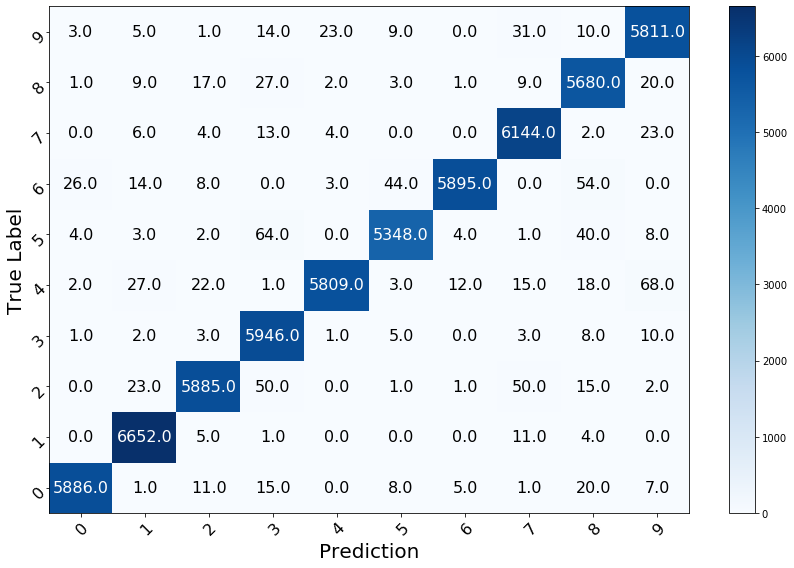

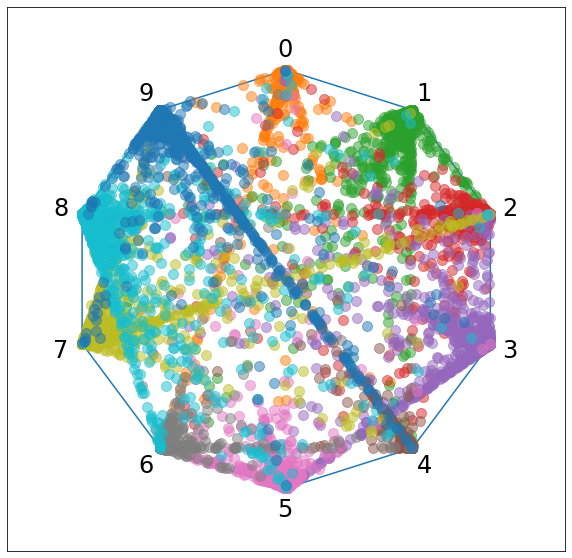

Test set accuracy mean 0.9344000000000001 std 0.0436077974678841


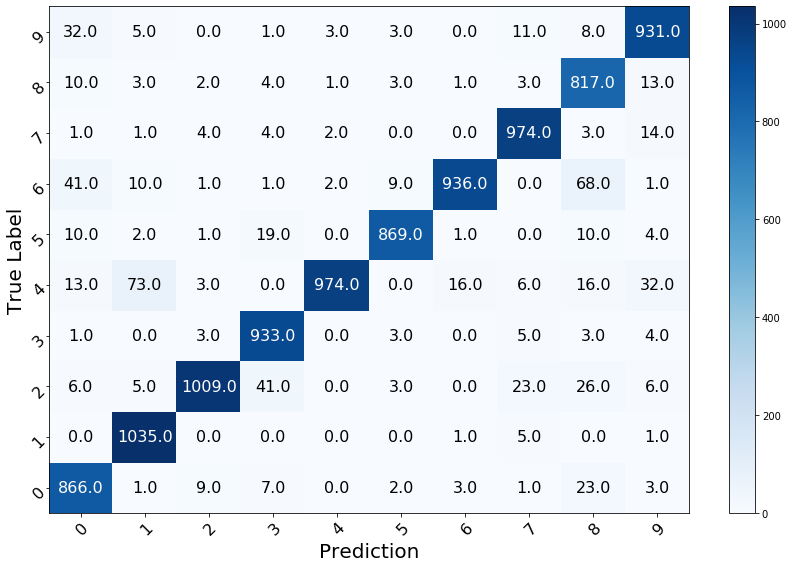

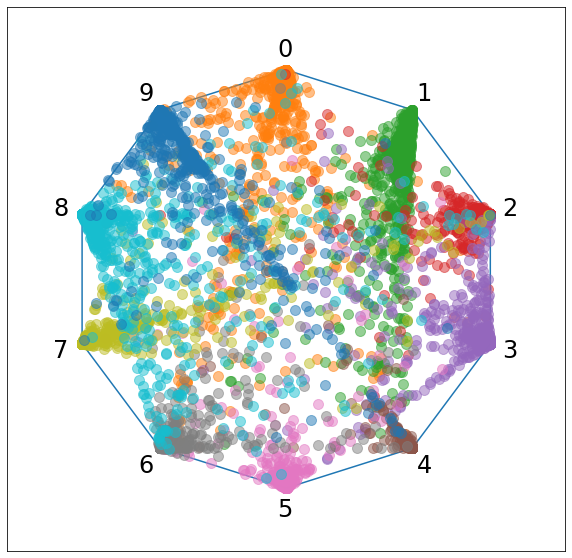

In [7]:
# For plotting a confusion matrix
from kmi.utils import inference_loop, plot_confusion_matrix, plot_softmax, restore_state

# Re-load the state if the weight_file is provided
if hasattr(blob,'weight_file') and blob.weight_file:
    restore_state(blob)

# For the Train set
accuracy, label, prediction, softmax = inference_loop(blob,train_loader,True)
print("Train set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])
plot_softmax(label,softmax)

# For the Test set
accuracy, label, prediction, softmax = inference_loop(blob,test_loader,False)
print("Test set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])
plot_softmax(label,softmax)